# Prediction with classifier

In [18]:
%matplotlib inline
import pandas as pd
from datetime import datetime
import numpy as np
import seaborn as sns
import pickle
#import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import xgboost
from model.models import TradeModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.grid_search import GridSearchCV
from pandas_ml import ConfusionMatrix
from service.files_service import get_files

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

Given a df with trade features(ATR,Keltner,Donchian), forecast if the next period will have a High with a pip higher than 10.

In [2]:
all_files = get_files(folder = 'data/all_data/resampled_D/',extension='.csv',as_dict=True,filter_on='_D_')

In [3]:
def make_prediction(tm,date):
    df = tm.df.copy()
   
    
    predictors =df.columns.tolist()
    df['target']=((df.High-df.High.shift(-1))*10000>=10)*1
    
    clf = xgboost.XGBClassifier()
    
    df_train = df[df.index<date]
    df_test = df[df.index==date]
 
    
      
    X_train,y_train = df_train[predictors].values,df_train.target.values
    X_test, y_test  = df_test[predictors].values,df_test.target.values
    
    clf = cv_optimize(clf,{},X_train,y_train)
    
    df_test['prediction'] = clf.predict(X_test)
    
    score =  clf.score(X_test,y_test)

    
    return y_test[0],df_test['prediction'][0],clf

def cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=5):
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=-1)
    gs.fit(Xtrain, ytrain)
    
    return gs.best_estimator_    

In [4]:
def compute_confusion_matrix(tm):
    real_result = []
    predicted_result=[]
    
    test_sample=100
    for dt in (tm.df.tail(test_sample).index.values):
        real,predicted,_ = make_prediction(tm, dt)
        break
        
        real_result.append(real)
        predicted_result.append(predicted)
        
    return ConfusionMatrix(real_result, predicted_result)

In [5]:
confusion_matrixes = {}
for k,v in all_files.iteritems():
    tm =TradeModel('data/all_data/resampled_D/'+v, name=k, datetime_col='ds')
    confusion_matrixes[k]=compute_confusion_matrix(tm)

TypeError: 'NoneType' object is not iterable

In [ ]:
confusion_matrixes['resampled_D_BRENTCMDUSD']

In [ ]:
pickle.dump(confusion_matrixes, open('data/confusion_matrix2.p', "wb"))

In [104]:
cmo = pickle.load(open('data/confusion_matrix2.p', "rb"))

In [105]:
df_CM_all = pd.DataFrame()
for k,v in cmo.iteritems():
    print v.stats_class.loc['PPV: Pos Pred Value (Precision)'][1]
    
    df_cm = cmo[k].to_dataframe()
    df_cm.index=[k +'_Actual_Negative',k +'_Actual_Positive']
    df_cm.columns=['Predicted_negative','Predicted_Positive']
    df_CM_all = pd.concat([df_CM_all,df_cm],axis=0)


0.692307692308
0.769230769231
0.628571428571
0.745098039216
0.738095238095
0.641025641026
0.842105263158
0.633333333333


## Results of prediction "is pip on day+1 on **High** > 10 ?" on 8 differents currencies

In [39]:
from datetime import timedelta
datetime(2016,12,8) - timedelta(100)

datetime.datetime(2016, 8, 30, 0, 0)

- each exchange rate dataset ranges from 2010/2011 until dec.8th 2016.
- we use the daily period.
- for the last 100 days of each dataset (ie 30th Aug 2016 until 8th dec 2016) : we compute the prediction that determine whether on day+1 the High value will be higher >10 pips.

The table below is a summary of the prediction vs the actual result per exchange-rate :

In [106]:
def testo(row):
    if  ('Positive' in row.name):
        return 1
    elif ('Negative' in row.name):
        return -1
    else :
        return 0

In [107]:
df_CM_all['win_lose']=df_CM_all.apply(testo,axis=1)


In [121]:
df_CM_all['gain_loss']=df_CM_all.win_lose * (100) * df_CM_all.Predicted_Positive
df_CM_all['invested']=df_CM_all.Predicted_Positive * (100)

In [122]:
df_CM_all

,Predicted_negative,Predicted_Positive,win_lose,gain_loss,invested
resampled_D_LIGHTCMDUSD_Actual_Negative,25,20,-1,-2000,2000
resampled_D_LIGHTCMDUSD_Actual_Positive,10,45,1,4500,4500
resampled_D_EURRUB_Actual_Negative,41,9,-1,-900,900
resampled_D_EURRUB_Actual_Positive,20,30,1,3000,3000
resampled_D_USDNOK_Actual_Negative,48,13,-1,-1300,1300
resampled_D_USDNOK_Actual_Positive,17,22,1,2200,2200
resampled_D_USDMXN_Actual_Negative,34,13,-1,-1300,1300
resampled_D_USDMXN_Actual_Positive,15,38,1,3800,3800
resampled_D_BRENTCMDUSD_Actual_Negative,42,11,-1,-1100,1100
resampled_D_BRENTCMDUSD_Actual_Positive,16,31,1,3100,3100


In [123]:
print df_CM_all.gain_loss.sum()
print df_CM_all.invested.sum()
print df_CM_all.gain_loss.sum()*1.0/df_CM_all.invested.sum()*100.0

14500
33900
42.7728613569


### Plot ROC Curve
See lab6-classification-redux.ipynb CS109-2015

In [35]:
def make_roc(name, clf, ytest, xtest, ax=None, labe=50, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    for k in xrange(0, fpr.shape[0],labe):
        #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
        threshold = str(np.round(thresholds[k], 2))
        ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

### Quick dirty method to test the ROC plotting

In [31]:
def test_ROC(date):
    tm =TradeModel('data/all_data/resampled_D/resampled_H_USDCAD_UTC_1 Min_Bid_2010.01.02_2016.12.08.csv',\
                   name='test', datetime_col='ds')
    df=tm.df.copy()
    
    predictors =df.columns.tolist()
    
    df['target']=((df.High-df.High.shift(-1))*10000>=10)*1
    
    clf = xgboost.XGBClassifier()
    
    df_train = df[df.index<date]
    df_test = df[df.index>=date]
 
    print df_test.shape
      
    X_train,y_train = df_train[predictors].values,df_train.target.values
    X_test, y_test  = df_test[predictors].values,df_test.target.values
    
    clf.fit(X_train,y_train)
    
    prediction = clf.predict_proba(X_test)
    
    return X_test, y_test,clf
    

In [32]:
X_test, y_test,clf = test_ROC(datetime(2016,12,8) - timedelta(100))

(2424, 18)


In [33]:
y_test

array([0, 0, 0, ..., 0, 0, 0])

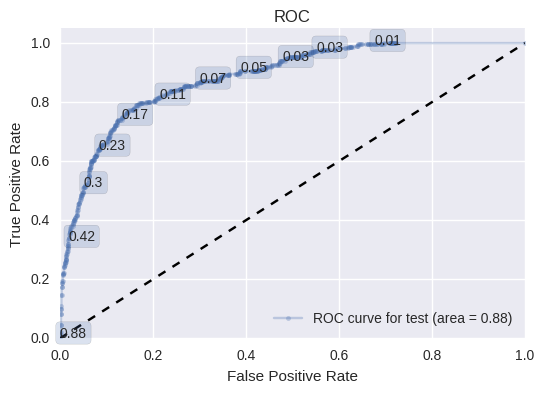

In [36]:
ax = make_roc('test',clf,y_test,X_test)